In [ ]:
%load_ext autoreload
%autoreload 2

## Getting started

In [ ]:
# Uncomment and run the next lines if Mesa and/or svgpath2mpl are missing
# !pip install -U "mesa[all]"
# !pip install svgpath2mpl

Execute each code cell with **Shift-Enter** and watch the output.


In [ ]:
from typing import Tuple

import matplotlib.pylab as plt
import seaborn as sns
import mesa
from mesa import Model
from mesa.datacollection import DataCollector
from mesa.experimental.continuous_space import ContinuousSpaceAgent, ContinuousSpace
import numpy as np
import pandas as pd


## 1 Model definition
We implement two classes:
* **`AntAgent`** – a single ant performing a correlated random walk.
* **`AntModel`** – the Mesa model that orchestrates agents and data collection.
The key idea is that after each step, the ant changes its heading by adding a value
drawn from the von Mises distribution $VM(0,\kappa)$, the circular analogue of the normal distribution.


In [243]:
class AntAgent(ContinuousSpaceAgent):
    """Continuous‑space ant executing a correlated random walk.

    Parameters
    ----------
    model : AntModel
        The parent Mesa model.
    space : ContinuousSpace
        The environment in which the ant moves (torus boundary).
    position : tuple[float, float]
        Initial *(x, y)* coordinates.
    speed : float, default=1.0
        Step length per tick.
    kappa : float, default=5.0
        Concentration of the von Mises distribution controlling turning angles.
    """
    def __init__(
            self,
            model: "AntModel",
            space: ContinuousSpace,
            position: Tuple[float, float],
            speed: float = 1.0,
            kappa: float = 5.0,
    ) -> None:
        super().__init__(space, model)
        self.position = np.asarray(position, dtype=float)
        self.heading: float = self.random.uniform(-np.pi, np.pi)  # radians
        self.speed: float = float(speed)

        # Random‑Walker parameters
        self.kappa = float(kappa)

        # Foraging state
        self.carrying: bool = False

    @property
    def _ixiy(self) -> Tuple[int, int]:
        """Current grid cell index (wrap torus)."""
        x, y = self.position
        return int(x) % self.model.width, int(y) % self.model.height

    @property
    def x(self) -> float:
        return float(self.position[0])

    @property
    def y(self) -> float:
        return float(self.position[1])

    def _move(self) -> None:
        """Translate position one step forward along the current heading."""
        dx = self.speed * np.cos(self.heading)
        dy = self.speed * np.sin(self.heading)
        self.position += (dx, dy)
        self.position = self.space.torus_correct(tuple(self.position))

    def _random_search(self) -> None:
        """Perform one correlated‑random‑walk step."""
        self._move()
        # Change heading; VM(0, kappa) –> mean 0, concentration kappa
        self.heading += self.random.vonmisesvariate(0, kappa=self.kappa)

    def _pickup_food(self) -> bool:
        ix, iy = self._ixiy
        if self.model.food[ix, iy] > 0:
            self.model.food[ix, iy] -= 1
            self.carrying = True
            return True
        return False

    def _return_to_nest(self) -> None:
        """Ballistic homing: aim directly at a nest center and move forward."""
        nest_x, nest_y = self.model._nest_center
        vec_x = nest_x - self.position[0]
        vec_y = nest_y - self.position[1]

        # Short‑circuit if we are already at nest cell
        if self.model.nest[
            int(self.position[0]) % self.model.width,
            int(self.position[1]) % self.model.height,
        ]:
            self.carrying = False
            self.heading += np.pi  # head back out next tick
            return

        # Orient towards nest
        self.heading = np.atan2(vec_y, vec_x)

        self._move()

    def step(self) -> None:
        if self.carrying:
            self._return_to_nest()
            return

        if self._pickup_food():
            # finish a step if food is found
            return

        # Perform an uninformed search as a fallback
        self._random_search()


In [ ]:
class AntModel(Model):
    """Mesa model containing one or more `AntAgent`s in continuous space.

    Parameters
    ----------
    width : int, default=101
        Length of the *x*-dimension (environment width).
    height : int, default=101
        Length of the *y*-dimension (environment height).
    n_ants : int, default=1
        Number of `AntAgent`s to create at initialisation.
    speed : float, default=1.0
        Step length (units per tick) assigned to each ant.
    kappa : float, default=5.0
        Concentration parameter of the von Mises turning‑angle distribution.
    seed : int | None, default=None
        Random seed fed to Mesa’s RNG.  Use a fixed value for reproducible
        trajectories; `None` draws a fresh seed at every run.

    Notes
    -----
    * The space is a **torus** – ants leaving one boundary re‑enter at the
      opposite edge (periodic boundary conditions).
    * All ants start in the center ``(width/2, height/2)``; modify the
      `position` argument of `AntAgent.create_agents` if you need a different
      initial distribution.
    """
    def __init__(
            self,
            width: int = 101,
            height: int = 101,
            n_ants: int = 10,
            speed: float = 1.0,
            kappa: float = 5.0,
            seed: int | None = None,
    ) -> None:
        super().__init__(seed=seed)
        self.width, self.height = width, height

        # Continuous space
        self.space = ContinuousSpace(
            [[0, width], [0, height]],
            torus=True,
            random=self.random,
            n_agents=n_ants,
        )

        AntAgent.create_agents(
            self,
            n_ants,
            self.space,
            position=np.tile(np.array([self.width / 2, self.height / 2]), (n_ants, 1)),
            speed=speed,
            kappa=kappa,
        )

        # Grid fields
        self.food = np.zeros((width, height), dtype=int)
        self.nest = np.zeros((width, height), dtype=bool)
        self._setup_patches()

        self.datacollector = DataCollector(
            # agent_reporters={
            #     "x": lambda agent: agent.x,
            #     "y": lambda agent: agent.y,
            #     "heading": lambda agent: agent.heading,
            # },
            model_reporters={
                "remaining_food": lambda m: m.food.sum(),
            }
        )

    def _setup_patches(self) -> None:
        cx, cy = self.width / 2, self.height / 2
        self._nest_center = (cx, cy)
        for x in range(self.width):
            for y in range(self.height):
                dist = np.hypot(x - cx, y - cy)
                if dist < 5:
                    self.nest[x, y] = True

        rng, radius = self.random, 5

        def _fill_circle(center: Tuple[float, float]):
            cx, cy = center
            for x in range(self.width):
                for y in range(self.height):
                    if np.hypot(x - cx, y - cy) < radius:
                        self.food[x, y] = rng.choice([1, 2])

        _fill_circle((0.8 * self.width, self.height / 2))  # right
        _fill_circle((0.2 * self.width, 0.2 * self.height))  # lower‑left
        _fill_circle((0.1 * self.width, 0.9 * self.height))  # upper‑left


    def step(self) -> None:
        self.agents.do("step")
        self.datacollector.collect(self)


## Visualization of one step in the simulation


In [ ]:
m1 = AntModel()

for _ in range(10):
    m1.step()

food = np.array(m1.food.copy(), dtype=np.float64)
food[food < 1] = np.nan
plt.imshow(food, cmap="Blues_r", vmax=5)

nest = np.array(m1.nest.copy(), dtype=np.float64)
nest[nest < 1] = np.nan
plt.imshow(nest, cmap="Purples_r", vmax=3, vmin=0)

for a in list(m1.agents):
    plt.scatter(a.x, a.y, c="k")

plt.show()


## Generate gifs


In [246]:
from matplotlib import animation
from IPython.display import HTML, Image, Video


STEPS = 200  # how many times you call m1.step()
INTERVAL_MS = 50  # delay between frames in the live preview
SAVE_SIMULATION = "ant_sim.mp4"  # or change extension to .mp4 for MP4 output

m1 = AntModel(seed=100, n_ants=20)

fig, ax = plt.subplots(figsize=(4,4))
im_food  = ax.imshow(np.zeros_like(m1.food, dtype=float), cmap="Blues_r",
                     vmax=5, animated=True)
im_nest  = ax.imshow(np.zeros_like(m1.nest, dtype=float), cmap="Purples_r",
                     vmax=3, vmin=0, animated=True)
scatter  = ax.scatter([], [], c="k", s=5, animated=True)
ax.axis("off")               # hide axes for a cleaner look

def init():
    """Blank first frame (required by FuncAnimation)."""
    im_food.set_data(np.full_like(m1.food, np.nan, dtype=float))
    im_nest.set_data(np.full_like(m1.nest, np.nan, dtype=float).T)
    # scatter.set_offsets([])
    return (im_food, im_nest, scatter)

def update(frame):
    """Called once per step; mutates `m1` and updates artists."""
    m1.step()                       # advance the model

    food = m1.food.astype(float)
    food[food < 1] = np.nan
    im_food.set_data(food)

    nest = m1.nest.astype(float)
    nest[nest < 1] = np.nan
    im_nest.set_data(nest)

    xy = np.array([[a.y, a.x] for a in m1.agents])

    colors  = ['gold' if a.carrying else 'black' for a in m1.agents]
    scatter.set_offsets(xy)
    scatter.set_color(colors)

    return (im_food, im_nest, scatter)

anim = animation.FuncAnimation(
    fig, update, frames=STEPS, init_func=init,
    blit=True, interval=INTERVAL_MS
);


In [ ]:
# Saving to a file (GIF or MP4)
# anim.save(SAVE_SIMULATION, writer="pillow", fps=1000//INTERVAL_MS)
# anim.save(SAVE_SIMULATION, writer="ffmpeg", fps=1000//INTERVAL_MS)

# Show the save file in Jupyter Notebook
# Image(SAVE_SIMULATION)
# Video(SAVE_SIMULATION)

# Or play animation directly in the Jupyter Notebook
HTML(anim.to_jshtml())



## Add ants SVG
⚠️ installing `svgpath2mpl` package is necessary


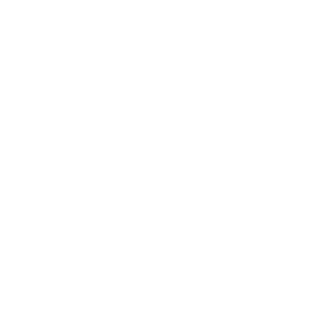

In [248]:
from matplotlib import transforms
from matplotlib.patches import PathPatch
# !pip install svgpath2mpl
from svgpath2mpl import parse_path


In [249]:
# SVG is copied from here: https://www.svgrepo.com/svg/436973/ant-fill

ANT_SVG_PATH = (
    """
   M 27.9883 55.9961 C 34.6211 55.9961 40.4101 48.8711 40.4101 41.2070 C 40.4101 40.0117 40.1992 39.0039 39.7773 38.1836 C 40.4570 38.3711 41.1367 38.5352 41.7930 38.7226 C 43.4101 39.1679 43.9023 39.8008 43.6679 41.2070 L 41.9570 52.4336 C 41.7461 53.7695 42.5664 54.5664 43.6679 54.5664 C 44.8164 54.5664 45.3320 53.8633 45.5195 52.6914 L 47.4414 40.5274 C 47.8867 37.7852 46.7617 36.2852 43.7617 35.5820 L 33.1914 33.1211 L 33.1679 32.8867 C 34.1758 32.3945 34.8554 31.4336 35.1601 30.3789 L 42.3554 29.3477 C 45.2852 28.9492 46.5976 27.3086 46.5976 24.4258 L 46.5976 16.3164 C 46.5976 15.1679 45.9414 14.5117 44.8164 14.5117 C 43.6914 14.5117 43.0352 15.1914 43.0352 16.3164 L 43.0352 23.6992 C 43.0352 25.3633 42.1445 25.9023 40.6211 26.1133 L 35.2539 26.8399 C 34.9961 26.1133 34.5273 25.4570 33.8945 25.0352 L 33.8945 24.8008 C 37.9023 24.0977 40.1289 21.6601 40.1289 18.0977 C 40.1289 15.0977 39.0039 12.3555 37.1758 10.2461 L 37.3867 10.0820 C 39.6601 8.4414 40.0820 6.0274 38.6054 3.4258 L 37.2226 1.1523 C 36.7773 .3555 36.2617 .39 35.5352 .39 C 34.5742 .39 33.8476 .7070 33.8476 1.6211 C 33.8476 2.0430 33.9179 2.2774 34.1758 2.7461 L 35.3945 4.5977 C 36.1445 5.8164 36.1445 6.8711 35.1836 7.7148 C 35.0664 7.8320 34.9258 7.9258 34.7852 8.0195 C 32.8398 6.7070 30.4961 5.9336 27.9883 5.9336 C 25.5273 5.9336 23.2070 6.7070 21.2852 7.9961 C 21.1679 7.9258 21.0039 7.8086 20.8867 7.6914 C 19.9492 6.8711 19.9258 5.8164 20.6992 4.5977 L 21.9179 2.7461 C 22.1758 2.2774 22.2461 2.0430 22.2461 1.6211 C 22.2461 .7070 21.5195 .39 20.5586 .39 C 19.8320 .39 19.3164 .3555 18.8711 1.1523 L 17.4883 3.4258 C 16.0117 6.0274 16.4336 8.4414 18.7070 10.0820 L 18.8711 10.1992 C 17.0195 12.3086 15.8476 15.0742 15.8476 18.0977 C 15.8476 21.6601 18.0976 24.0977 22.1054 24.8008 L 22.1054 25.0352 C 21.4726 25.4570 21.0039 26.1133 20.7461 26.8399 L 15.3789 26.1133 C 13.8320 25.9023 12.9648 25.3633 12.9648 23.6992 L 12.9648 16.3164 C 12.9648 15.1914 12.3086 14.5117 11.1836 14.5117 C 10.0586 14.5117 9.4023 15.1679 9.4023 16.3164 L 9.4023 24.4258 C 9.4023 27.3086 10.7148 28.9492 13.6445 29.3477 L 20.8398 30.3789 C 21.1445 31.4336 21.8242 32.3945 22.8320 32.8867 L 22.8320 33.1211 L 12.2383 35.5820 C 9.2148 36.2852 8.1133 37.7852 8.5586 40.5274 L 10.4805 52.6914 C 10.6445 53.8633 11.1836 54.5664 12.3320 54.5664 C 13.4336 54.5664 14.2539 53.7695 14.0430 52.4336 L 12.3320 41.2070 C 12.0976 39.8008 12.5898 39.1679 14.2070 38.7226 C 14.8632 38.5352 15.5430 38.3711 16.2226 38.1836 C 15.8008 39.0039 15.5898 40.0117 15.5898 41.2070 C 15.5898 48.8711 21.3789 55.9961 27.9883 55.9961 Z
    """
)
ant_path = parse_path(ANT_SVG_PATH)
# compute the path’s bounding-box centre …
xmin, ymin, xmax, ymax = ant_path.get_extents().bounds
cx, cy = (xmin + xmax) / 2, (ymin + ymax) / 2         # mid-point
# … and shift *all* vertices so that centre becomes (0, 0)
ant_path.vertices -= [cx, cy]

ANT_SIZE   = 0.05
ANT_ZORDER = 4            # draws ants on top of every other layer

STEPS = 100  # how many times you call m1.step()
INTERVAL_MS = 50  # delay between frames in the live preview

m1 = AntModel(seed=100, n_ants=20)

fig, ax = plt.subplots(figsize=(4,4))
im_food  = ax.imshow(np.zeros_like(m1.food, dtype=float), cmap="Blues_r",
                     vmax=5, animated=True)
im_nest  = ax.imshow(np.zeros_like(m1.nest, dtype=float), cmap="Purples_r",
                     vmax=3, vmin=0, animated=True)
scatter  = ax.scatter([], [], c="k", s=5, animated=True)
ax.axis("off")               # hide axes for a cleaner look

ant_patches = []

def init():
    """Blank first frame (required by FuncAnimation)."""
    im_food.set_data(np.full_like(m1.food, np.nan, dtype=float))
    im_nest.set_data(np.full_like(m1.nest, np.nan, dtype=float).T)
    # scatter.set_offsets([])
    return (im_food, im_nest, scatter)

def update(frame):
    """Called once per step; mutates `m1` and updates artists."""
    m1.step()  # advance the model

    food = m1.food.astype(float)
    food[food < 1] = np.nan
    im_food.set_data(food)

    nest = m1.nest.astype(float)
    nest[nest < 1] = np.nan
    im_nest.set_data(nest)

    # ANT layer
    # 1) wipe previous step’s ants
    for p in ant_patches:
        p.remove()
    ant_patches.clear()

    # 2) create one rotated copy of the path per agent
    for a in m1.agents:
        trans = (transforms.Affine2D()
                 .rotate(np.pi - a.heading)
                 .scale(ANT_SIZE)
                 .translate(a.y, a.x)          # drop onto the ant position
                 + ax.transData)               # then into data coords

        patch = PathPatch(
            ant_path,
            transform=trans,
            fc='gold'  if a.carrying else 'black',   # colour logic
            ec='none',
            lw=0,
            zorder=ANT_ZORDER,
        )
        ax.add_patch(patch)
        ant_patches.append(patch)

    return im_food, im_nest, *ant_patches

anim = animation.FuncAnimation(
    fig, update, frames=STEPS, init_func=init,
    blit=True, interval=INTERVAL_MS
);


In [ ]:
# Saving to a file (GIF or MP4)
# anim.save(SAVE_SIMULATION, writer="pillow", fps=1000//INTERVAL_MS)
# anim.save(SAVE_SIMULATION, writer="ffmpeg", fps=1000//INTERVAL_MS)

# Show the save file in Jupyter Notebook
# Image(SAVE_SIMULATION)
# Video(SAVE_SIMULATION)

# Or play animation directly in the Jupyter Notebook
HTML(anim.to_jshtml())


## Resource consumption analysis


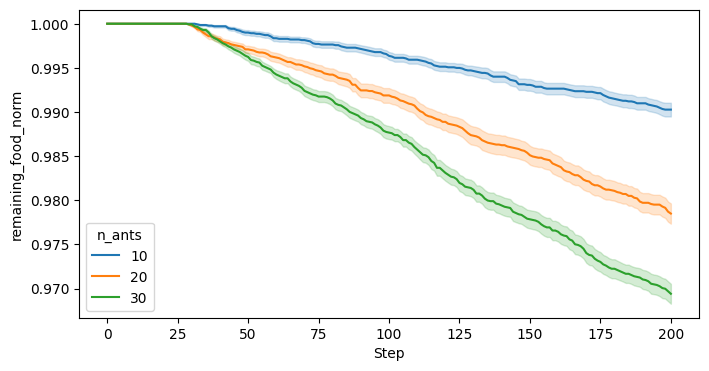

In [251]:
import multiprocessing
n_cpu = multiprocessing.cpu_count()


In [ ]:
from model import AntModel as AntModelFromFile

BATCH_PARAMS = {
    "n_ants": [10, 20, 30],  # try different colony sizes
    "kappa": [5.0],       # keep turning stiffness fixed for now
}

batch_results = mesa.batch_run(
    AntModelFromFile,
    parameters=BATCH_PARAMS,
    iterations=40,         # replicate each parameter set 20 times
    max_steps=200,
    number_processes=n_cpu,    # set >1 for parallel execution on multi‑core machines
    data_collection_period=1,  # collect at every step (required for MSD)
    display_progress=True,
)

batch_results = pd.DataFrame(batch_results)
batch_results.dropna(inplace=True)
batch_results.head()


In [260]:
cols = ['n_ants', 'iteration', 'kappa'] # the grouping keys

batch_results['remaining_food_norm'] = (
        batch_results['remaining_food'] /
        batch_results.groupby(cols)['remaining_food'].transform('max')
)

g = sns.lineplot(
    data=batch_results,
    x="Step",
    y="remaining_food_norm",
    hue="n_ants",
    errorbar="se",
    palette="tab10",
)
g.figure.set_size_inches(8, 4)
plt.show()


## Resource consumption analysis (only the last step)


In [253]:
from model import AntModel as AntModelFromFile

BATCH_PARAMS = {
    "n_ants": [10, 20, 30],  # try different colony sizes
    "kappa": [5.0],       # keep turning stiffness fixed for now
}

batch_results = mesa.batch_run(
    AntModelFromFile,
    parameters=BATCH_PARAMS,
    iterations=40,         # replicate each parameter set 20 times
    max_steps=200,
    number_processes=n_cpu,    # set >1 for parallel execution on multi‑core machines
    data_collection_period=-1,  # collect at the last step
    display_progress=True,
)

batch_results = pd.DataFrame(batch_results)
batch_results.dropna(inplace=True)
batch_results.head()


(120, 6)

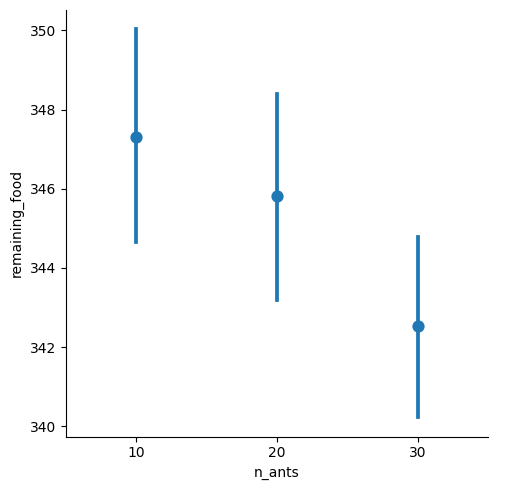

In [254]:
batch_results.shape


In [ ]:
sns.catplot(
    batch_results,
    x="n_ants",
    y="remaining_food",
    kind="point",
    linestyle='none'
)
plt.show()
